<a href="https://colab.research.google.com/github/vedurmaliya/Intrusion-Detection/blob/main/Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, ZeroPadding2D, LeakyReLU
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



In [3]:
df = pd.read_csv('/preprocessedCIC.csv').sample(frac=1).reset_index(drop=True)[:200000]
df = df.replace([np.inf, -np.inf], np.nan).dropna()

In [4]:
df.shape

(20416, 39)

In [5]:
df["Label"].value_counts()

,count
Label,
BENIGN,17425
DoS Hulk,1479
DDoS,1017
PortScan,214
DoS GoldenEye,76
FTP-Patator,55
DoS slowloris,45
DoS Slowhttptest,38
SSH-Patator,36


In [6]:
cl = len(df["Label"].value_counts())
cl

12

In [7]:
# Define the minority and majority classes
minority_class = ['Web Attack  Sql Injection', 'Infiltration', 'Web Attack  XSS']
majority_class = ['BENIGN', 'DoS Hulk', 'DDoS', 'PortScan', 'Web Attack  Brute Force', 'Bot', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'SSH-Patator', 'DoS GoldenEye']

# Split the dataset into minority and majority
minority = df[df['Label'].isin(minority_class)].reset_index(drop=True)
majority = df[df['Label'].isin(majority_class)].reset_index(drop=True)

In [8]:
enn = NearestNeighbors(n_neighbors=500)
enn.fit(majority.drop(columns=['Label']))
difficult_idx = enn.kneighbors(minority.drop(columns=['Label']), return_distance=False).flatten()
difficult = df.iloc[difficult_idx]
easy = df.reset_index(drop=True).drop(difficult_idx)

In [9]:
difficult["Label"].value_counts()

,count
Label,
BENIGN,1670
DoS Hulk,149
DDoS,119
PortScan,23
DoS slowloris,11
SSH-Patator,9
FTP-Patator,9
DoS GoldenEye,6
Web Attack  Brute Force,4


In [10]:
easy["Label"].value_counts()

,count
Label,
BENIGN,16835
DoS Hulk,1427
DDoS,976
PortScan,204
DoS GoldenEye,72
FTP-Patator,52
DoS slowloris,42
DoS Slowhttptest,38
SSH-Patator,33


In [11]:
# Use KMeans to compress majority samples in the difficult set
kmeans = KMeans(n_clusters=100)
kmeans.fit(difficult.drop(columns=['Label']))
compressed = pd.DataFrame(kmeans.cluster_centers_, columns=difficult.columns[:-1])
compressed['Label'] = 'BENIGN'

In [12]:
# Generate synthetic minority samples in the difficult set
difficult_min = difficult[difficult['Label'].isin(minority_class)]
difficult_max = difficult[difficult['Label'] == 'BENIGN']
difficult_range = difficult_max - difficult_min
difficult_samples = pd.DataFrame()

In [13]:
for i in range(10):
  r = pd.DataFrame(columns=difficult_min.columns[:-1])
  random_values = np.random.rand(difficult_min.shape[1]-1)
  r.loc[0] = random_values
  dm = difficult_min.iloc[:,:-1]
  sample = dm.add(r, fill_value=0)
  sample['Label'] = minority_class[np.random.randint(0, len(minority_class))]
  difficult_samples = pd.concat([difficult_samples, sample], ignore_index=True)

In [14]:
new_train_set = pd.concat([easy, compressed, difficult_min, difficult_samples])
df2 = new_train_set.sample(frac=1).reset_index(drop=True)

In [15]:
df2

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Flow Bytes/s,Flow Packets/s,Fwd IAT Total,Bwd IAT Total,...,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Label
0,17.0,36589.0,4.0,4.0,168.0,232.0,1.093225e+04,218.644948,36422.0,36443.0,...,58.0,4.0,168.0,4.0,232.0,-1.0,-1.0,3.0,20.0,BENIGN
1,6.0,84505321.0,6.0,6.0,375.0,11595.0,1.416479e+02,0.142003,84400000.0,84500000.0,...,1932.5,6.0,375.0,6.0,11595.0,0.0,235.0,3.0,20.0,DoS Hulk
2,6.0,254454.0,4.0,6.0,716.0,11595.0,4.838203e+04,39.299834,225994.0,254442.0,...,1932.5,4.0,716.0,6.0,11595.0,29200.0,235.0,2.0,32.0,DoS Hulk
3,17.0,170.0,2.0,2.0,86.0,118.0,1.200000e+06,23529.411760,4.0,48.0,...,59.0,2.0,86.0,2.0,118.0,-1.0,-1.0,1.0,32.0,BENIGN
4,17.0,47.0,2.0,0.0,124.0,0.0,2.638298e+06,42553.191490,47.0,0.0,...,0.0,2.0,124.0,0.0,0.0,-1.0,-1.0,1.0,32.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19814,6.0,120796.0,8.0,5.0,521.0,3749.0,3.534885e+04,107.619458,120796.0,52507.0,...,749.8,8.0,521.0,5.0,3749.0,8192.0,343.0,7.0,20.0,BENIGN
19815,17.0,300.0,2.0,2.0,86.0,204.0,9.666667e+05,13333.333330,4.0,3.0,...,102.0,2.0,86.0,2.0,204.0,-1.0,-1.0,1.0,32.0,BENIGN
19816,6.0,80.0,1.0,1.0,6.0,6.0,1.500000e+05,25000.000000,0.0,0.0,...,6.0,1.0,6.0,1.0,6.0,15544.0,65098.0,0.0,20.0,BENIGN
19817,6.0,35868348.0,14.0,15.0,820.0,8304.0,2.543747e+02,0.808512,35900000.0,359589.0,...,553.6,14.0,820.0,15.0,8304.0,8192.0,360.0,13.0,20.0,BENIGN


In [16]:
df2["Label"].value_counts()

,count
Label,
BENIGN,16935
DoS Hulk,1427
DDoS,976
PortScan,204
DoS GoldenEye,72
FTP-Patator,52
DoS slowloris,42
DoS Slowhttptest,38
SSH-Patator,33


In [17]:
X_train, X_test, y_train, y_test = train_test_split(df2.iloc[:,:-1], df2.iloc[:,-1], test_size=0.3, random_state=42)

In [18]:
to_remove = [x for x in y_test.unique() if x not in y_train.unique()]
rows_to_remove = y_test.isin(to_remove)

y_test = y_test[~rows_to_remove]
X_test = X_test[~rows_to_remove]

In [19]:
X_train.shape

(13873, 38)

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train1 = X_train
X_test1 = X_test

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [22]:
unique_labels = le.transform(df2['Label'].unique())

In [23]:
# Convert the training and testing data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

param = {'max_depth': 10, 'eta': 1}
num_round = 10
bst = xgb.train(param, dtrain, num_round)

y_pred = bst.predict(dtest)
y_pred = np.round(y_pred).astype(int)

accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.75%


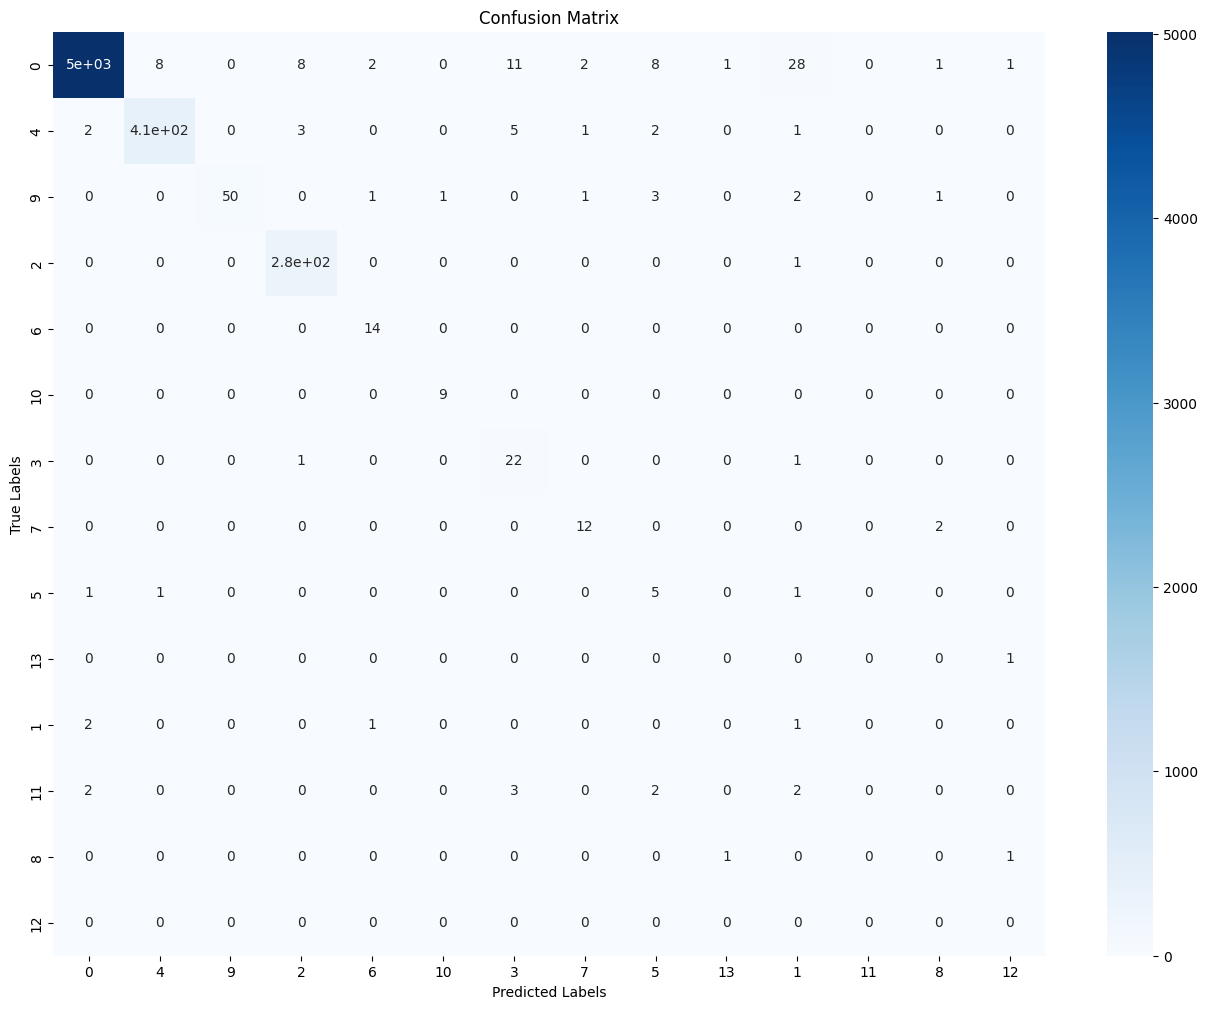

In [24]:
cm = confusion_matrix(y_test_encoded, y_pred, labels=unique_labels)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()

In [25]:
!pip install -q keras-tuner
import keras_tuner as kt

# Prepare your data for LSTM
X1_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X1_test  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
num_classes = len(np.unique(y_train_encoded))
print("Number of unique classes in training data:", num_classes)

# Define the hypermodel
def build_model(hp):
    model = Sequential()

    # Tune number of layers: 1 or 2 LSTM layers
    n_layers = hp.Int('num_lstm_layers', 1, 2)
    for i in range(n_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
        return_seq = (i < n_layers - 1)
        if i == 0:
            model.add(LSTM(units,
                           activation='tanh',
                           return_sequences=return_seq,
                           input_shape=(X1_train.shape[1], X1_train.shape[2])))
        else:
            model.add(LSTM(units,
                           activation='tanh',
                           return_sequences=return_seq))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

    # Optional Dense block
    if hp.Boolean('use_dense_layer'):
        dense_units = hp.Int('dense_units', 16, 128, step=16)
        model.add(Dense(dense_units))
        model.add(LeakyReLU(alpha=hp.Float('leaky_alpha', 0.1, 0.5, step=0.1)))
        model.add(Dropout(hp.Float('dropout_dense', 0.1, 0.5, step=0.1)))

    # Output
    model.add(Dense(num_classes, activation='softmax'))

    # Compile with tuned learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_tuner_dir',
    project_name='lstm_tuning'
)

# Run the hyperparameter search
tuner.search(
    X1_train, y_train_encoded,
    epochs=20,
    validation_data=(X1_test, y_test_encoded),
    batch_size=32
)

# Summarize results
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters:")
for param in best_hp.values:
    print(f"  {param}: {best_hp.get(param)}")

# Retrieve the best model and evaluate
best_model = tuner.get_best_models(num_models=1)[0]
loss, acc = best_model.evaluate(X1_test, y_test_encoded)
print(f"\nTest accuracy: {acc*100:.2f}%")


Trial 10 Complete [00h 01m 35s]
val_accuracy: 0.9600571990013123

Best val_accuracy So Far: 0.9848637580871582
Total elapsed time: 00h 25m 19s

Best hyperparameters:
  num_lstm_layers: 1
  units_0: 96
  dropout_0: 0.2
  use_dense_layer: False
  learning_rate: 0.01
  units_1: 128
  dropout_1: 0.2
  dense_units: 128
  leaky_alpha: 0.30000000000000004
  dropout_dense: 0.2
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9823 - loss: 0.0834

Test accuracy: 98.52%


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test Recall: 98.52%
Test F1 Score: 98.41%



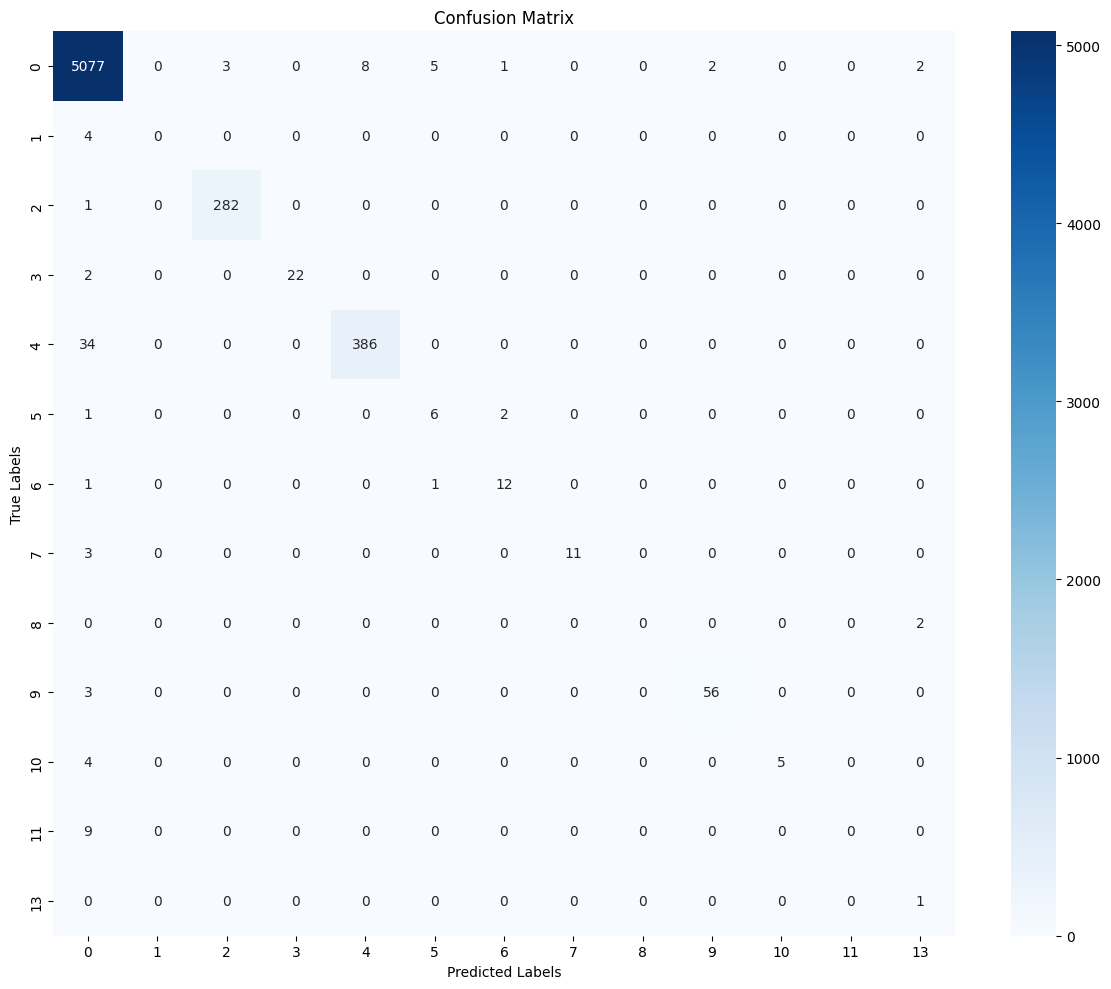

In [27]:
from sklearn.metrics import recall_score, f1_score

y_pred_proba = best_model.predict(X1_test, batch_size=32)
y_pred = np.argmax(y_pred_proba, axis=-1)

recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1     = f1_score(   y_test_encoded, y_pred, average='weighted')
print(f"Test Recall: {recall*100:.2f}%")
print(f"Test F1 Score: {f1*100:.2f}%\n")

unique_labels = np.unique(np.concatenate([y_test_encoded, y_pred]))
cm = confusion_matrix(y_test_encoded, y_pred, labels=unique_labels)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels,
            ax=ax)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
X2_train = X_train.reshape((X_train.shape[0], 19, 2, 1))
X2_test = X_test.reshape((X_test.shape[0], 19, 2, 1))
# Check the number of unique labels in your training data
num_classes = len(np.unique(y_train_encoded))
print("Number of unique classes in training data:", num_classes)

# MINI-VGGNet model
model = Sequential()
model.add(Conv2D(32, (2, 1), activation='relu', input_shape=(19, 2, 1)))
model.add(Conv2D(32, (2, 1), activation='relu'))
model.add(MaxPooling2D((2, 1)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X2_train, y_train_encoded, epochs=10, validation_data=(X2_test, y_test_encoded))

results = model.evaluate(X2_test,y_test_encoded)
print("\n\nAccuracy: %.2f%%" % (results[1]*100))

Number of unique classes in training data: 14
Epoch 1/10
434/434 [==============================] - 5s 10ms/step - loss: 0.4045 - accuracy: 0.9137 - val_loss: 0.2127 - val_accuracy: 0.9344
Epoch 2/10
434/434 [==============================] - 3s 7ms/step - loss: 0.2203 - accuracy: 0.9338 - val_loss: 0.1666 - val_accuracy: 0.9445
Epoch 3/10
434/434 [==============================] - 3s 6ms/step - loss: 0.1793 - accuracy: 0.9475 - val_loss: 0.1390 - val_accuracy: 0.9569
Epoch 4/10
434/434 [==============================] - 2s 6ms/step - loss: 0.1554 - accuracy: 0.9532 - val_loss: 0.1319 - val_accuracy: 0.9549
Epoch 5/10
434/434 [==============================] - 3s 6ms/step - loss: 0.1383 - accuracy: 0.9568 - val_loss: 0.1451 - val_accuracy: 0.9600
Epoch 6/10
434/434 [==============================] - 3s 8ms/step - loss: 0.1279 - accuracy: 0.9613 - val_loss: 0.1022 - val_accuracy: 0.9716
Epoch 7/10
434/434 [==============================] - 2s 6ms/step - loss: 0.1198 - accuracy: 0.9632 -

186/186 [==============================] - 1s 3ms/step


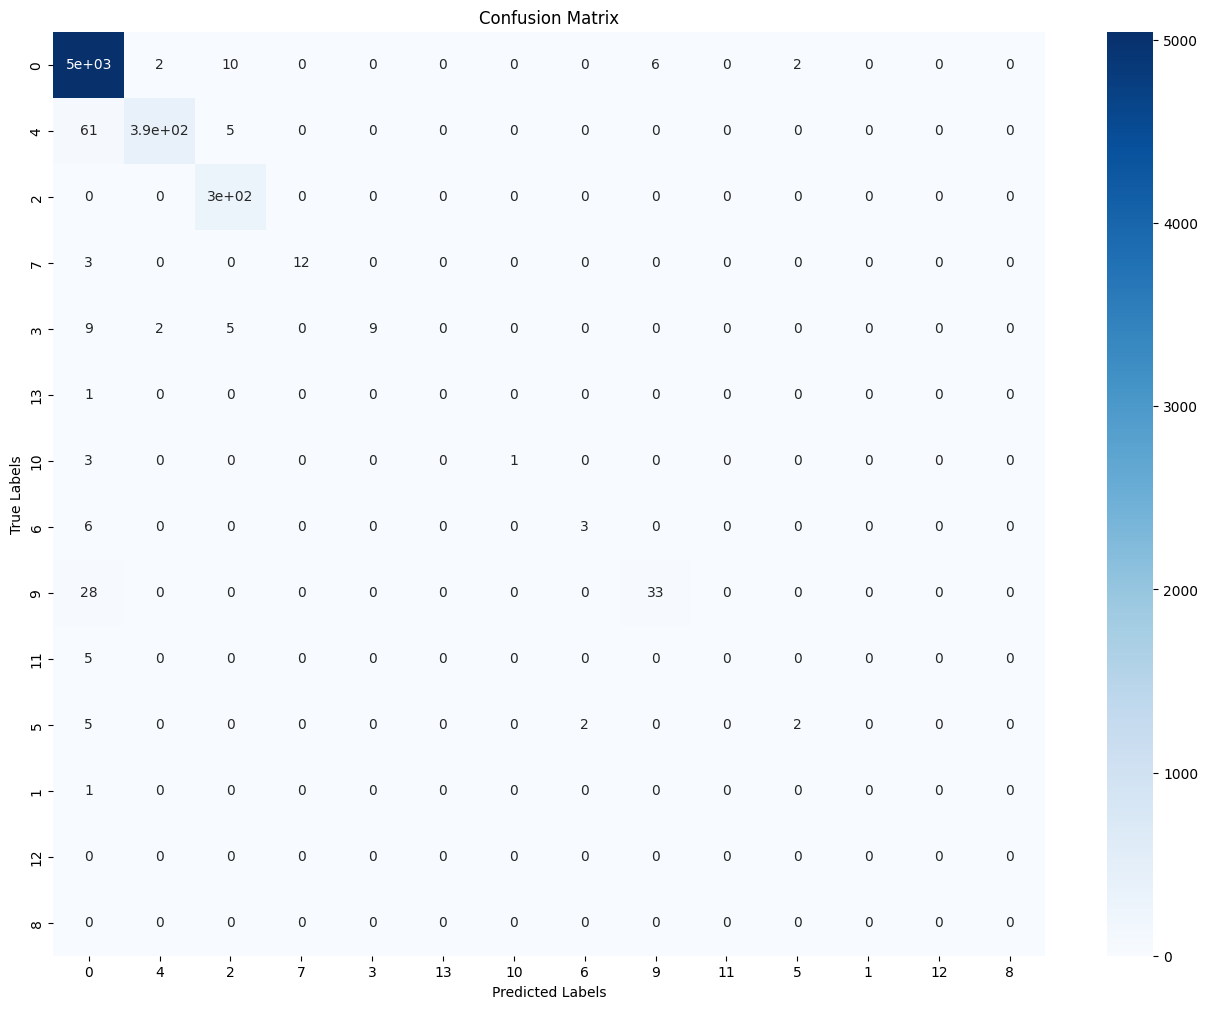

In [ ]:
y_pred = np.argmax(model.predict(X2_test), axis=-1)

cm = confusion_matrix(y_test_encoded, y_pred, labels=unique_labels)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()

In [ ]:
# Define the AlexNet model
model = Sequential()
model.add(Conv2D(filters=96, kernel_size=(2,1), strides=(4,4), activation='relu', input_shape=(19, 2, 1)))
model.add(MaxPooling2D(pool_size=(2,1), strides=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,1), strides=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2,1), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1), strides=(1,1)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
# Determine the number of unique classes
num_classes = len(np.unique(y_train_encoded))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X2_train, y_train_encoded, epochs=2, validation_data=(X2_test, y_test_encoded))

results = model.evaluate(X2_test,y_test_encoded)
print("\n\nAccuracy: %.2f%%" % (results[1]*100))

Epoch 1/2
434/434 [==============================] - 203s 461ms/step - loss: 0.8707 - accuracy: 0.8073 - val_loss: 0.7062 - val_accuracy: 0.8651
Epoch 2/2
186/186 [==============================] - 9s 50ms/step - loss: 0.3396 - accuracy: 0.9124


Accuracy: 91.24%


186/186 [==============================] - 8s 40ms/step


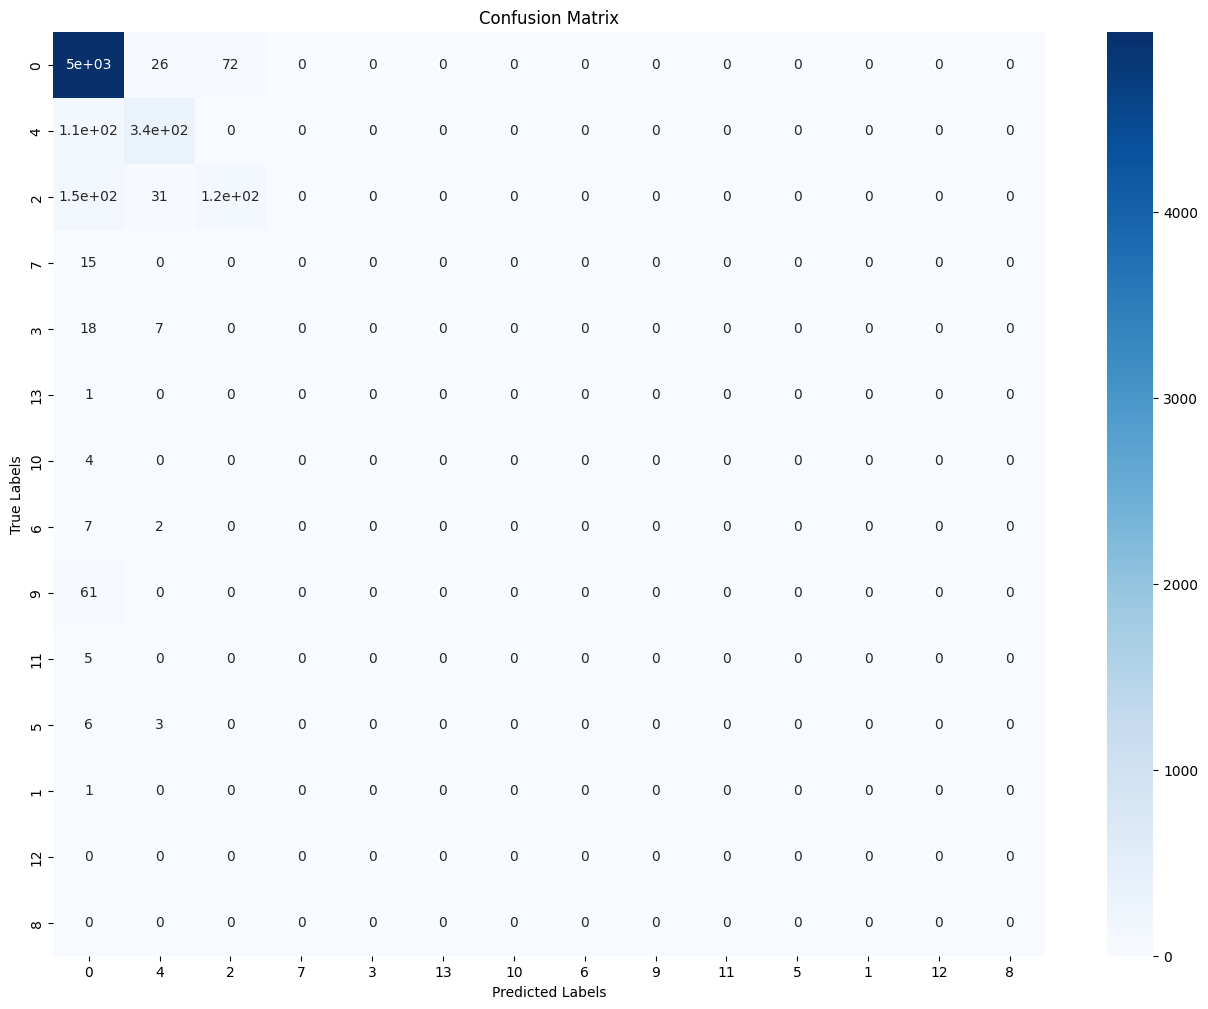

In [ ]:
y_pred = np.argmax(model.predict(X2_test), axis=-1)

cm = confusion_matrix(y_test_encoded, y_pred, labels=unique_labels)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.show()